In [3]:
!pip3 install ipympl matplotlib numpy scipy abspy pyglet pyembree trimesh tqdm networkx scikit-learn colorlog python-fcl

# Генератор формы

Чтобы опробовать идеи я взял простой примитив - куб. По задумке реальные данные будут представлять из себя облака точек, поэтому куб генерируется как облако случайных точек на его поверхности с некоторым шумом.

In [4]:
%matplotlib inline
%matplotlib widget
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import trimesh
cube_sizes = (85.0 / 1000 + 0.02, 0.02, 85.0 / 1000 + 0.02)


In [5]:
def generate_points(sizes, count, max_diviation = 0):
    ret = []
    for i in range(count):
        s = np.random.randint(0, 5)
        c =  s % 3
        rs = [0]*3
        rs[c] = -sizes[c]/2 if s > 2 else sizes[c] /2
        rs[c] += max_diviation * np.random.random()
        rs[(c+1)%3] = sizes[(c+1)%3] * np.random.random() - sizes[(c+1)%3]/2
        rs[(c+2)%3] = sizes[(c+2)%3] * np.random.random() - sizes[(c+2)%3]/2
        ret.append(rs)
    return np.array(ret)

def plot_setup(subplots_shape = (1,1), n = 1):
    fig = plt.figure()
    ax = fig.add_subplot(*subplots_shape, n, projection='3d')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    return ax, fig

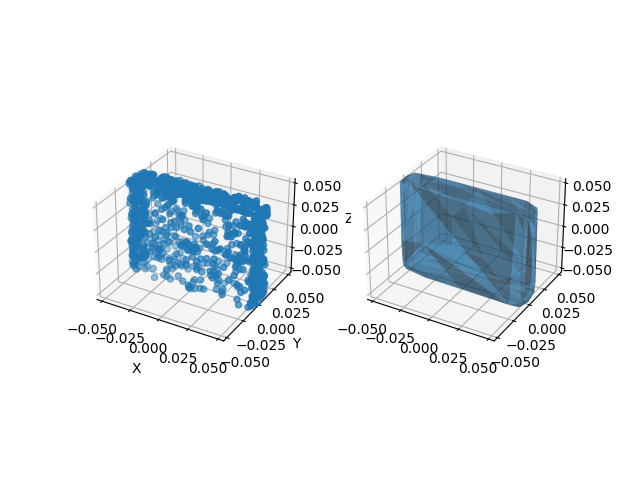

In [6]:
plot_size = (1,2)
ax, fig = plot_setup(plot_size, 1)
data = generate_points(cube_sizes, 1000, 0.002)
ax.scatter(data[:,0], data[:, 1], data[:,2])
for a in ['x', 'y', 'z']:
    eval(f'ax.set_{a}lim')(-max(cube_sizes)/2, max(cube_sizes)/2)

from scipy.spatial import ConvexHull
tri = ConvexHull(data)
ax = fig.add_subplot(*plot_size, 2, projection='3d')
for a in ['x', 'y', 'z']:
    eval(f'ax.set_{a}lim')(-max(cube_sizes)/2, max(cube_sizes)/2)
ax.plot_trisurf(data[:,0],data[:,1], data[:,2], triangles = tri.simplices, alpha=0.5)
plt.show()

# Схват

Упрощенная схема захвата представляет из себя подобную фигуру:

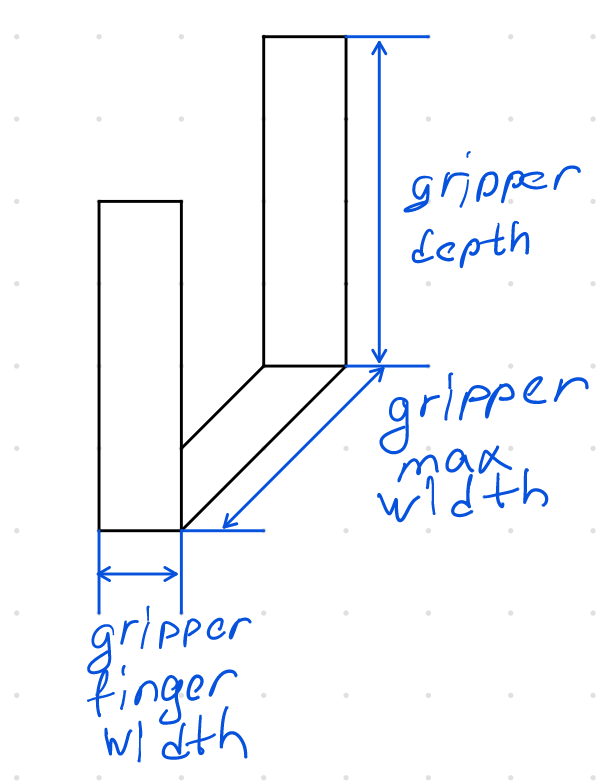

In [7]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
class Gripper:
    gripper_depth = 59.3 / 1000
    gripper_max_width = 85.0 / 1000
    gripper_finger_width = 22.0 / 1000
    def GetGeometry(self):
        x_dim = self.gripper_max_width/2
        y_dim = self.gripper_finger_width/2
        geometry = {
            'back_plane' : np.array([
                    [-1, -1, 0],
                    [ 1, -1, 0],
                    [ 1,  1, 0],
                    [-1,  1, 0],
                ]) * [x_dim, y_dim, self.gripper_depth],
            'right_plane' : np.array([
                    [ 1, -1,  0],
                    [ 1,  1,  0],
                    [ 1,  1,  1],
                    [ 1, -1,  1],
                ]) * [x_dim, y_dim, self.gripper_depth]
        }
        geometry['left_plane'] = geometry['right_plane'] * [-1, 1, 1]
        triangles = {key:  [[0,1,2],[2,3,0], [1, 0, 2], [3, 2, 0]] for key in geometry}
        return geometry, triangles
        
    def GetInternalGeometry(self):
        from scipy.spatial import ConvexHull
        geom, _ = self.GetGeometry()
        internal_points = np.concatenate([geom['right_plane'], geom['left_plane']])
        tri = ConvexHull(internal_points)
        return tri
    
    def GetPolygons(self):
        geom, _ = self.GetGeometry()
        back_plane  = geom['back_plane']
        right_plane = geom['right_plane']
        left_plane  = geom['left_plane']
        return Poly3DCollection([back_plane, right_plane, left_plane], color='g', alpha=0.2)

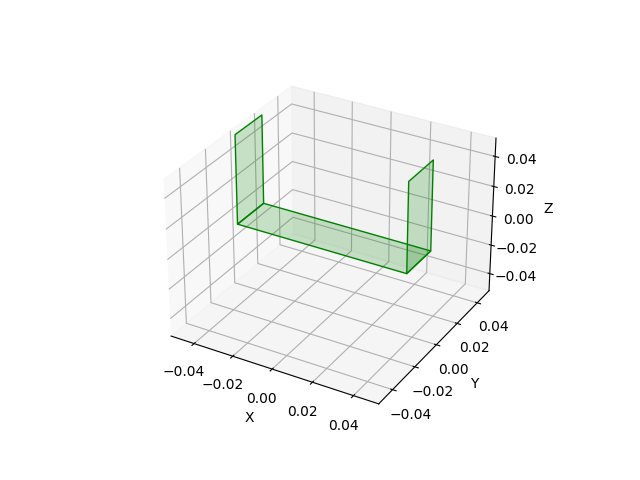

In [8]:
gripper = Gripper()
ax, fig = plot_setup()
polygons = gripper.GetPolygons()
ax.add_collection3d(polygons)
# ax.scatter([0],[0], [0])
bounds = 0.05
for a in ['x', 'y', 'z']:
    eval(f'ax.set_{a}lim')(-bounds, bounds)

# Trimesh

trimesh библиотека удобная для работы с 3д представлениями объектов. В этом сегменте производятся преобразования из ConvexHull (scipy) в Trimesh. Это нужно для проверки коллизий объектов.

In [9]:
def build_convex_normals(points, i_simpleces):
    simpleces = points[i_simpleces]
    centroid = np.sum(simpleces, 0).sum(axis=0)
    centroid /= simpleces.shape[0]*simpleces.shape[1]
    for i, tg in enumerate(simpleces):
        pmid = (tg[0] + tg[1] + tg[2])/3.0
        n = np.cross(tg[1] - tg[0], tg[2]-tg[0])
        n /= np.linalg.norm(n)
        dot_product = np.dot(n, pmid-centroid)
        if dot_product < 0:
            i_simpleces[i, [2,1]] = i_simpleces[i, [1,2]]

    return i_simpleces

In [10]:
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R

from trimesh import Trimesh
from trimesh.collision import CollisionManager

In [11]:
def CnvxToTrimesh(cvx):
    i_simpleces = build_convex_normals(cvx.points, cvx.simplices)
    mesh = Trimesh(cvx.points, i_simpleces)
    return mesh

In [12]:
gripper_geometry, triangles = gripper.GetGeometry()
gripper_meshes = { key : Trimesh(gripper_geometry[key], triangles[key]) for key in gripper_geometry}
from trimesh.scene.scene import Scene
sc = Scene()
for key in gripper_meshes:
    sc.add_geometry(gripper_meshes[key])
mesh = CnvxToTrimesh(tri)
mesh.visual.face_colors = trimesh.visual.random_color()
sc.add_geometry(mesh, transform= [[1, 0, 0, 0.1], [0, 1, 0, 0 ], [0, 0, 1, 0], [0, 0, 0, 1]])
sc.show()

# Table

In [13]:

table_mesh = trimesh.load('../objects/recon_iter_900.obj')
table_mesh.apply_scale(0.005)
table_mesh.visual.face_colors= trimesh.visual.random_color()
sc = trimesh.Scene()
sc.add_geometry(table_mesh, transform= [[1, 0, 0,0], [0, 1, 0,0], [0, 0, -1,0.29], [0, 0, 0,1]])
sc.add_geometry(mesh)
sc.show()

# Оптимизация позы

In [14]:

collisionManager = CollisionManager()
collisionManager.add_object('box', mesh)
collisionManager.add_object('table', table_mesh, transform= [[1, 0, 0,0], [0, 1, 0,0], [0, 0, -1,0.29], [0, 0, 0,1]])

In [15]:
def PoseToMatrix(pose):
    m = np.zeros((4,4))
    m[0:3, 0:3] = R.from_rotvec(pose[3:]).as_matrix()
    m[0:3, 3] = pose[:3]
    return m

## Loss

$$ \vec{\mathbf{x}} \in \rm I\!R^3 \text{ -target shape position} $$
$$ \vec{\mathbf{x}}' \in \rm I\!R^3 \text{ -optimized position} $$
$$ \vec{\mathbf{r}}' \in \rm I\!R^3 \text{ -optimized rotvec} $$
$$ \mathbf{x} \text{ -target shape} $$
$$ \mathbf{y}_1 \text{ -gripper shape} $$
$$ \mathbf{y}_2 \text{ -gripper internal shape} $$


$$ \mathcal{C}(\mathbf{x, y}) \rightarrow t_1 \in \{0,1\}, \mathbf{d} \in \rm I\!R^n, \mathbf{p} \in \rm I\!R^{n \times 3} $$
$$ \mathcal{R}(\vec{\mathbf{r}}') \rightarrow R \in  \rm I\!R^{3 \times 3} $$
$$ 
\mathbf{D}(\vec{\mathbf{x}}, \vec{\mathbf{x}}', t_1 ) = 
\begin{cases}
    |\vec{\mathbf{x}} - \vec{\mathbf{x}}'|, & t_1=0 \\
    0,               & t_1 = 1
\end{cases} 
$$

$$ \mathbf{C}(\mathbf{x, y_1, \vec{\mathbf{x}}'}) = \sum_{i=1}^{n}{  \mathcal{C}(\mathbf{x, y_1})_{1,i} |\mathcal{C}(\mathbf{x, y_1})_{2, i} - \vec{\mathbf{x}}'| } $$

$$ \mathbf{T}(\mathbf{x, y_2, \vec{\mathbf{x}}'}) = -\sum_{i=1}^{n}{   \frac{\mathcal{C}(\mathbf{x, y_2})_{1,i}}{|\mathcal{C}(\mathbf{x, y_2})_{2, i} + \vec{\mathbf{x}}'|} }$$

$$ \mathbf{O}(\vec{\mathbf{x}}, \vec{\mathbf{r}}') = | \mathcal{R}(\vec{\mathbf{r}}') \times \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}  \times \vec{\mathbf{x}}|  $$

$$ \mathbf{L = C + \frac{D + O + T/C}{C}} $$


In [16]:
history = []
def loss(tfx, args):
    tf = PoseToMatrix(tfx)
    history.append(tf[:3, 3].tolist())
    collMngr = args['mngr']
    meshDict = args['meshes']
    collTargetMesh = args['internal']
    collision_loss = 10**-10
    target_collision_loss = 10**-10
    orient_loss = np.linalg.norm(np.cross(- tf[:3,:3] @ [0, 0, 1], tf[:3, 3]))
    
    for key in meshDict:
        is_collide, contacts = collMngr.in_collision_single(gripper_meshes[key], tf, False,True)
        for cd in contacts:
            collision_loss += cd.depth*np.linalg.norm(cd.point - tfx[:3])
            
    dist_loss = np.linalg.norm(tfx[0:3]) if not is_collide else 0

    is_collide, names, contacts = collMngr.in_collision_single(collTargetMesh, tf, True,True)    
    for name, cd in zip(names, contacts):
        if name == 'table': continue
        target_collision_loss -= cd.depth*np.linalg.norm(cd.point + tfx[:3])


    return collision_loss + (dist_loss + orient_loss + target_collision_loss/collision_loss)/collision_loss

In [41]:
history = []
tf0 = np.array([0, 0.5, -0.5, np.random.random(), np.random.random(), np.random.random()])
# tf0 = np.array([[ 0.00722719, -0.00328817, -0.02397669, -0.13674422, -0.00262615,  1.51724677]])
gripper_internal_mesh = CnvxToTrimesh(gripper.GetInternalGeometry())
rs = minimize(
                loss, 
                tf0, 
                method='Powell', 
                # method='CG', 
                args={
                        'mngr' : collisionManager, 
                        'meshes' : gripper_meshes,
                        'internal' : gripper_internal_mesh,
                        'adaptive' : True
                        },
                options={'disp': True, 'maxiter' : 10**5, 'fatol' : 10**-10, 'xatol':10**-10})

tf = PoseToMatrix(rs.x)
print(tf)
print(rs.x)
sc = Scene()
for key in gripper_meshes:
    sc.add_geometry(gripper_meshes[key], transform=tf)
sc.add_geometry(mesh, transform=np.eye(4,4))
# history = [ [0, np.sin(i/np.math.pi), np.cos(i/np.math.pi)] for i in range(100)]
el = trimesh.path.entities.Line(list(range(len(history))))
print(history[0])
path = trimesh.path.Path3D([el], vertices=history, colors=[trimesh.visual.random_color()])
# sc.add_geometry(path)
sc.add_geometry( table_mesh, transform= [[1, 0, 0,0], [0, 1, 0,0], [0, 0, -1,0.29], [0, 0, 0,1]])
sc.show()

/tmp/ipykernel_536/3800137022.py:5: OptimizeWarning: Unknown solver options: fatol, xatol
  rs = minimize(


Optimization terminated successfully.
         Current function value: -154336778.910765
         Iterations: 7
         Function evaluations: 963
[[ 0.85414269  0.28114081 -0.43749299 -0.06384358]
 [-0.35823119 -0.29174874 -0.88687828  0.08285635]
 [-0.37697571  0.91424423 -0.14848164  0.00402872]
 [ 0.          0.          0.          0.        ]]
[-0.06384358  0.08285635  0.00402872  1.75968518 -0.059125   -0.62466236]
[0.0, 0.5, -0.5]


In [49]:
def test():
    history = []
    tf0 = np.array([np.random.random()*2 -1, np.random.random()*2-1, np.random.random()*2-1, np.random.random()*np.math.pi*2-np.math.pi, np.random.random()*np.math.pi*2 -np.math.pi, np.random.random()*np.math.pi*2 - np.math.pi])
    # tf0 = np.array([[ 0.00722719, -0.00328817, -0.02397669, -0.13674422, -0.00262615,  1.51724677]])
    gripper_internal_mesh = CnvxToTrimesh(gripper.GetInternalGeometry())
    rs = minimize(
                    loss, 
                    tf0, 
                    method='Powell', 
                    # method='CG', 
                    args={
                            'mngr' : collisionManager, 
                            'meshes' : gripper_meshes,
                            'internal' : gripper_internal_mesh,
                            'adaptive' : True
                            },
                    options={'disp': False, 'maxiter' : 10**5})
#     rs = minimize(
#                     loss, 
#                     rs.x, 
#                     # method='Powell', 
#                     method='CG', 
#                     args={
#                             'mngr' : collisionManager, 
#                             'meshes' : gripper_meshes,
#                             'internal' : gripper_internal_mesh,
#                             'adaptive' : True
#                             },
#                     options={'disp': False, 'maxiter' : 10**5})
    tf = PoseToMatrix(rs.x)
    internal = collisionManager.in_collision_single(gripper_internal_mesh, tf)
    gripper_col = any([collisionManager.in_collision_single(gripper_meshes[m], tf) for m in gripper_meshes ])
    return internal and not gripper_col

%time rs = np.array([test() for i in range(1000)])
print(np.nonzero(rs)[0].shape)

CPU times: user 5min 13s, sys: 490 ms, total: 5min 13s
Wall time: 5min 13s
(458,)


In [50]:
def test():
    history = []
    tf0 = np.array([np.random.random()*2 -1, np.random.random()*2-1, np.random.random()*2-1, np.random.random()*np.math.pi*2-np.math.pi, np.random.random()*np.math.pi*2 -np.math.pi, np.random.random()*np.math.pi*2 - np.math.pi])
    # tf0 = np.array([[ 0.00722719, -0.00328817, -0.02397669, -0.13674422, -0.00262615,  1.51724677]])
    gripper_internal_mesh = CnvxToTrimesh(gripper.GetInternalGeometry())
    rs = minimize(
                    loss, 
                    tf0, 
                    method='Powell', 
                    # method='CG', 
                    args={
                            'mngr' : collisionManager, 
                            'meshes' : gripper_meshes,
                            'internal' : gripper_internal_mesh,
                            'adaptive' : True
                            },
                    options={'disp': False, 'maxiter' : 10**5})
    rs = minimize(
                    loss, 
                    rs.x, 
                    # method='Powell', 
                    method='CG', 
                    args={
                            'mngr' : collisionManager, 
                            'meshes' : gripper_meshes,
                            'internal' : gripper_internal_mesh,
                            'adaptive' : True
                            },
                    options={'disp': False, 'maxiter' : 10**5})
    tf = PoseToMatrix(rs.x)
    internal = collisionManager.in_collision_single(gripper_internal_mesh, tf)
    gripper_col = any([collisionManager.in_collision_single(gripper_meshes[m], tf) for m in gripper_meshes ])
    return internal and not gripper_col

%time rs = np.array([test() for i in range(1000)])
print(np.nonzero(rs)[0].shape)

CPU times: user 6min 51s, sys: 340 ms, total: 6min 51s
Wall time: 6min 51s
(491,)
